In [1]:
#Importing necessary files
import gensim
import pandas as pd
import numpy as np
import gensim.downloader as api
import io
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
from nltk import word_tokenize
import nltk
from tqdm import tqdm
from scipy.spatial.distance import cosine, euclidean, cityblock, minkowski
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#Code to import CSV file in Google Colab; use output file from the preprocessing notebook
from google.colab import files
uploaded = files.upload()

Saving quora_preprocessed_v2.csv to quora_preprocessed_v2.csv


In [3]:
#Reading the data in colab
df_data = pd.read_csv(io.StringIO(uploaded['quora_preprocessed_v2.csv'].decode('utf-8')))

In [4]:
df_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0


In [5]:
#Pre-trained Google word2vec model
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-29 02:18:14--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  79.6MB/s    in 20s     

2020-11-29 02:18:34 (79.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [6]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [7]:
stops = stopwords.words('english')

In [8]:
#Change datatype of questions to string
df_data['question1'] = df_data['question1'].astype('str')
df_data['question2'] = df_data['question2'].astype('str')

In [9]:
#Length of questions
df_data['q1_char_length'] = df_data['question1'].apply(len)
df_data['q2_char_length'] = df_data['question2'].apply(len)

#Absolute difference in lengths
df_data['char_length_diff'] = abs(df_data['q1_char_length'] - df_data['q2_char_length'])

In [10]:
#Word match ratio is the ratio of the 2*number of common words in the two questions to the total number of words

def word_match_ratio(row):
    q1words = []
    q2words = []
    
    for word in re.sub(r'[^\w\s]', '', row['question1']).lower().split():
        if word not in stops and word not in q1words:
            q1words.append(word)
    
    for word in re.sub(r'[^\w\s]', '', row['question2']).lower().split():
        if word not in stops and word not in q2words:
            q2words.append(word)
    
    
    shared_words = [w for w in q1words if w in q2words]
    
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    
    ratio = (2*len(shared_words))/(len(q1words) + len(q2words))
    
    return ratio

In [11]:
df_data['ratio'] = df_data.apply(word_match_ratio, axis=1)

In [12]:
df_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,char_length_diff,ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,64,55,9,0.909091
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,46,79,33,0.363636
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,66,53,13,0.545455
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,43,51,8,0.000000
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,68,37,31,0.266667


In [16]:
#Word mover distance
def wm_dist(a, b):
  a = a.lower().split()
  a = [i for i in a if i not in stops]
  b = b.lower().split()
  b = [i for i in b if i not in stops]

  return word2vec.wmdistance(a, b)

In [17]:
#Create column for word mover distance
df_data['wm_dist'] = df_data.apply(lambda x: wm_dist(x['question1'], x['question2']), axis=1)

In [18]:
#Normalize the word2vec vectors. This is done to calculate the normalized word mover distance.
word2vec.init_sims(replace=True)

In [19]:
#Normalized word mover distance
df_data['nwm_dist'] = df_data.apply(lambda x: wm_dist(x['question1'], x['question2']), axis=1)

In [23]:
#Calculating a vector for each sentence from its words
def sentence_vec(a):
  a = a.lower()#.decode('utf-8')
  a = word_tokenize(a)

  a = [i for i in a if not i in stops]
  a = [i for i in a if i.isalpha()]

  M = []
  for i in a:
    try:
      M.append(word2vec[i])
    except:
      continue
    
  M = np.array(M)

  v = M.sum(axis=0)
  return v/(np.sqrt((v**2).sum()))

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
#Create vectors for each question from their words. Each question will be represented by a vector of length 300.
#TQDM is just a function to keep track of the for loop

q1_vecs = np.zeros((df_data.shape[0], 300))
q2_vecs = np.zeros((df_data.shape[0], 300))

for i, q1 in tqdm(enumerate(df_data['question1'].values)):
  q1_vecs[i,:] = sentence_vec(q1)

for i, q2 in tqdm(enumerate(df_data['question2'].values)):
  q2_vecs[i,:] = sentence_vec(q2)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
404012it [01:20, 5049.14it/s]
404012it [01:20, 4998.85it/s]


In [25]:
#NAN to num converts nan to 0 and inf to high integer values
q1_vecs = np.nan_to_num(q1_vecs)
q2_vecs = np.nan_to_num(q2_vecs)

In [26]:
#Computing different distance metrics using the sentence vectors
cosine_dist = []
euclidean_dist = []
manhattan_dist = []
minkowski3_dist = []

for i in range(0, len(q1_vecs)):
  cosine_dist.append(cosine(q1_vecs[i,], q2_vecs[i,]))
  euclidean_dist.append(euclidean(q1_vecs[i,], q2_vecs[i,]))
  manhattan_dist.append(cityblock(q1_vecs[i,], q2_vecs[i,]))
  minkowski3_dist.append(minkowski(q1_vecs[i,], q2_vecs[i,],3))

df_data['cosine_dist'] = cosine_dist
df_data['euclidean_dist'] = euclidean_dist
df_data['manhattan_dist'] = manhattan_dist
df_data['minkowski3_dist'] = minkowski3_dist

#Deleting variables from memory
del cosine_dist, manhattan_dist, minkowski3_dist, euclidean_dist

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [27]:
#Deleting word2vec object from memory
del word2vec

In [28]:
df_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,char_length_diff,ratio,wm_dist,nwm_dist,cosine_dist,euclidean_dist,manhattan_dist,minkowski3_dist
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,64,55,9,0.909091,0.627381,0.193716,0.038742,0.278360,3.825459,0.126338
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,46,79,33,0.363636,3.464976,1.152752,0.527316,1.026953,14.064819,0.461656
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,66,53,13,0.545455,1.549404,0.583051,0.190648,0.617491,8.448144,0.282513
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,43,51,8,0.000000,2.879803,1.325666,0.787716,1.255162,17.506925,0.573209
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,68,37,31,0.266667,2.384850,0.900424,0.312893,0.791066,10.988392,0.354279


In [30]:
#Install fuzzywuzzy library
pip install fuzzywuzzy

In [31]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [32]:
#Fuzzy features

#QRatio
df_data['QRatio'] = df_data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)

#WRatio
df_data['WRatio'] = df_data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)

#Partial Ratio
df_data['Partial_Ratio'] = df_data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)

#Partial Token Set Ratio
df_data['Partial_Token_Set_Ratio'] = df_data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)

#Partial Token Sort Ratio
df_data['Partial_Token_Sort_Ratio'] = df_data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

#Token Set Ratio
df_data['Token_Set_Ratio'] = df_data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)

#Token Sort Ratio
df_data['Token_Sort_Ratio'] = df_data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [33]:
df_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,char_length_diff,ratio,wm_dist,nwm_dist,cosine_dist,euclidean_dist,manhattan_dist,minkowski3_dist,QRatio,WRatio,Partial_Ratio,Partial_Token_Set_Ratio,Partial_Token_Sort_Ratio,Token_Set_Ratio,Token_Sort_Ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,64,55,9,0.909091,0.627381,0.193716,0.038742,0.278360,3.825459,0.126338,92,95,100,100,87,100,92
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,46,79,33,0.363636,3.464976,1.152752,0.527316,1.026953,14.064819,0.461656,66,86,70,100,76,81,64
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,66,53,13,0.545455,1.549404,0.583051,0.190648,0.617491,8.448144,0.282513,39,68,38,100,70,72,64
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,43,51,8,0.000000,2.879803,1.325666,0.787716,1.255162,17.506925,0.573209,21,27,26,32,32,28,28
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,68,37,31,0.266667,2.384850,0.900424,0.312893,0.791066,10.988392,0.354279,36,86,54,100,72,68,50


In [34]:
#Creating a copy
df_data2 = df_data

#Replace inf with NAN
df_data2.replace([np.inf, -np.inf], np.nan, inplace=True)

#Drop columns that aren't needed
cols_to_drop = ['id','qid1','qid2','question1','question2','is_duplicate']

#Split dependent and independent variables
X = df_data2.drop(cols_to_drop, axis=1)
y = df_data2['is_duplicate']

#Impute NAN with mean value for each column
X = X.fillna(X.mean())

### Modelling

In [35]:
#Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123, stratify = y)

In [36]:
#Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

#Standardise test set and predict
X_test_scaled = scaler.transform(X_test)

#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy is 68.63799874591598
Precision is 58.19465334044928
Recall is 53.585150107219434
F1 score is 55.79485986742644


In [37]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 68.95069469654467
Precision is 57.88973173806312
Recall is 58.47033595425304
F1 score is 58.17858531977551


In [38]:
#kNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 71.89861720735288
Precision is 62.139488481770364
Recall is 61.21783416726233
F1 score is 61.67521829147539


In [39]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 75.12953367875647
Precision is 66.7991545283279
Recall is 64.94594353109365
F1 score is 65.85951480281787


In [40]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()

ab_clf.fit(X_train, y_train)

y_pred = ab_clf.predict(X_test)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 71.12636546648625
Precision is 59.92766579973993
Recall is 65.88187991422446
F1 score is 62.76387470207695


In [41]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 73.26655885944359
Precision is 63.351904638507385
Recall is 65.53118298784847
F1 score is 64.42311915323467


In [42]:
#XGBoost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(objective='binary:logistic')
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 72.68737005379361
Precision is 62.54193548387097
Recall is 64.96157969978556
F1 score is 63.72879870272165


### Tuning the Random Forest model

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = {
    #'bootstrap': [True, False],
    #'max_depth': [10, 20, 40, 50, 75, 100, None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [100, 200, 300, 500]
}

In [50]:
rfc = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 10, cv = 3, verbose=10, random_state=42, n_jobs = -1)

In [51]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 81.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [52]:
#Best Accuracy score from grid search
rf_random.best_score_

0.7532035839039111

In [53]:
#Parameters for best model
rf_random.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}

In [54]:
rf1 = rf_random.best_estimator_

In [55]:
#Predict on test set
y_pred = rf1.predict(X_test)

#Assessing test set metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is {}".format(acc*100))
print("Precision is {}".format(precision*100))
print("Recall is {}".format(recall*100))
print("F1 score is {}".format(f1*100))

Accuracy is 75.61054090624071
Precision is 67.07232188966478
Recall is 66.72623302358828
F1 score is 66.8988298527518


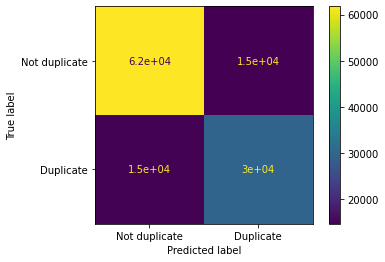

In [56]:
from sklearn.metrics import plot_confusion_matrix

#Plot confusion matrix for test data
plot_confusion_matrix(rf1, X_test, y_test, display_labels = ['Not duplicate','Duplicate'])